Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular, Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
from decorrelation.plotting import *
from decorrelation.utils import generate_correlated_data

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def train(num_epochs, data, model):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        model.forward(data)
        L[i] = model.update()

    # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

We start by showing effective decorrelation of correlated input

mean variance: 1.00


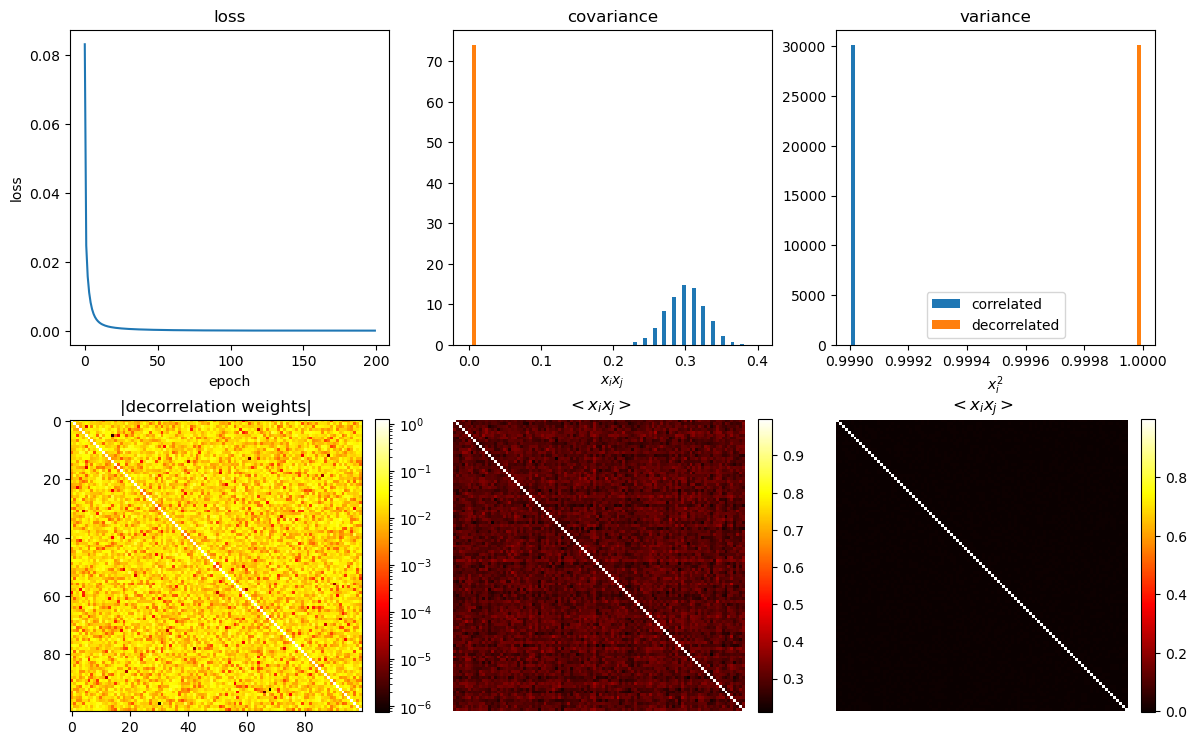

In [4]:
num_samples=1000
num_features=100
num_epochs=200
seed=42
decor_lr=1e-0
bias_lr=0.0
kappa=1e-1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = generate_correlated_data(num_features, num_samples).to(device)

# create a decorrelator
model = Decorrelation(in_features=num_features, decor_lr=decor_lr, bias_lr=bias_lr, kappa=kappa).to(device)
train
L, A1, A2 = train(num_epochs, data, model)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')


Show the same for learning a lower triangular matrix

mean variance: 1.00


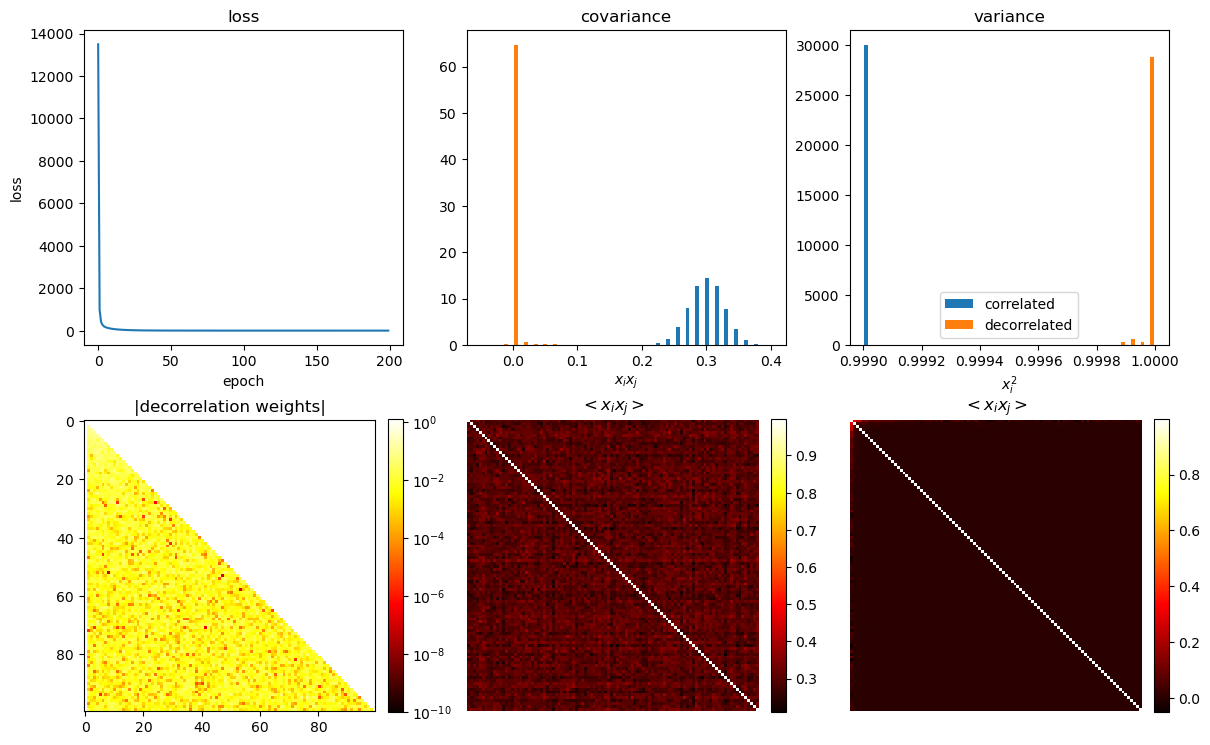

In [10]:
num_samples=1000
num_features=100
num_epochs=200
seed=42
decor_lr=1e-2
kappa=1e-1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = generate_correlated_data(num_features, num_samples).to(device)

# create a decorrelator
model = Decorrelation(in_features=num_features, decor_lr=1e-2, bias_lr=bias_lr, kappa=kappa, full=False).to(device)

L, A1, A2 = train(num_epochs, data, model)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')


Show the impact of debiasing of the data (will have positive effect if weights start to grow during optimization; may allow even higher stable decorrelation learning rates)

mean variance: 1.00


tensor([-0.3242, -0.3539, -0.3194, -0.2950, -0.2416, -0.2351, -0.2972, -0.3283,
        -0.3283, -0.3060, -0.2966, -0.2559, -0.3611, -0.2947, -0.3283, -0.3125,
        -0.2476, -0.3096, -0.2741, -0.2944, -0.2702, -0.2249, -0.3089, -0.2780,
        -0.3539, -0.3036, -0.1952, -0.3304, -0.2943, -0.3831, -0.2940, -0.2753,
        -0.2658, -0.2970, -0.2780, -0.3541, -0.2523, -0.3646, -0.2950, -0.3014,
        -0.3410, -0.2849, -0.3151, -0.2572, -0.3010, -0.2463, -0.3195, -0.3061,
        -0.1901, -0.3689, -0.3337, -0.2820, -0.3155, -0.2838, -0.2701, -0.3082,
        -0.2607, -0.3239, -0.2955, -0.3400, -0.3666, -0.3397, -0.2622, -0.3230,
        -0.3028, -0.2914, -0.2796, -0.2252, -0.2900, -0.2776, -0.2756, -0.2675,
        -0.2662, -0.3630, -0.2626, -0.3026, -0.2361, -0.3686, -0.2330, -0.2879,
        -0.3509, -0.2481, -0.2967, -0.3312, -0.2686, -0.3058, -0.2746, -0.2818,
        -0.3879, -0.3027, -0.2204, -0.2604, -0.3495, -0.3795, -0.3013, -0.2446,
        -0.3682, -0.3072, -0.3182, -0.26

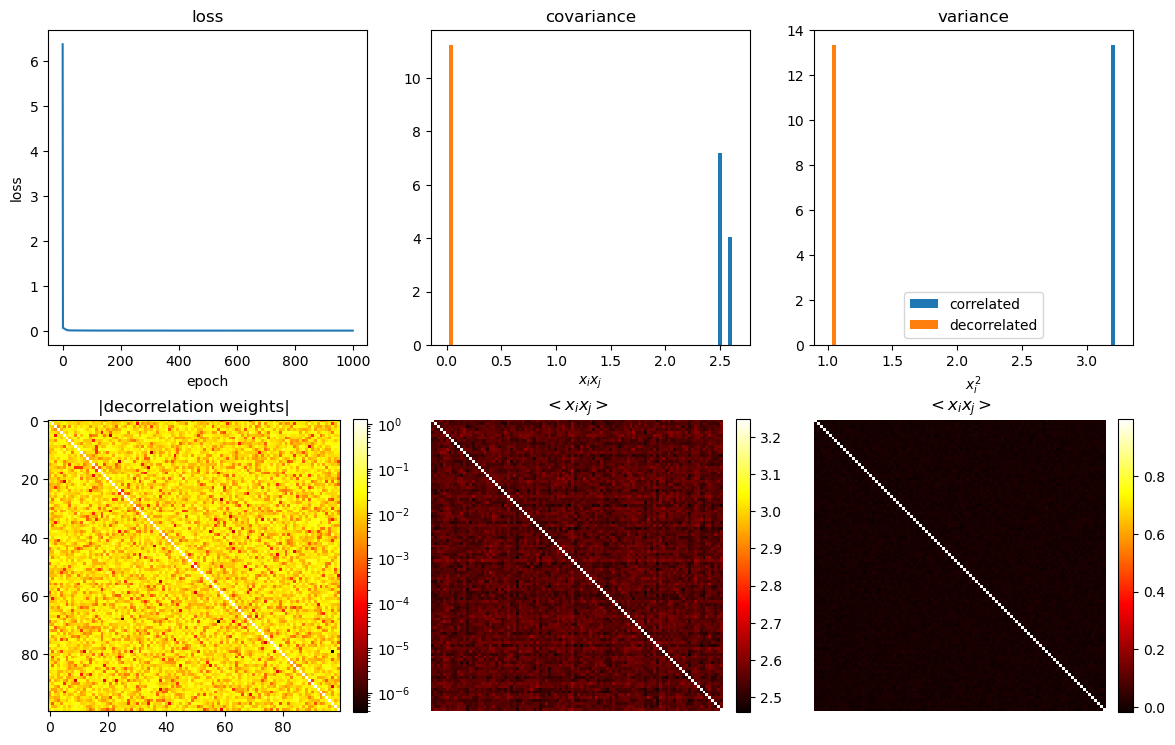

In [11]:
num_samples=1000
num_features=100
num_epochs=1000
seed=42
decor_lr=1e-1
bias_lr=1e-1
kappa=1e-1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = generate_correlated_data(num_features, num_samples).to(device) + 1.5

# create a decorrelator
model = Decorrelation(in_features=num_features, decor_lr=decor_lr, bias_lr=bias_lr, kappa=kappa).to(device)

L, A1, A2 = train(num_epochs, data, model)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')
model.bias

Shows how offsets lead to huge gradients

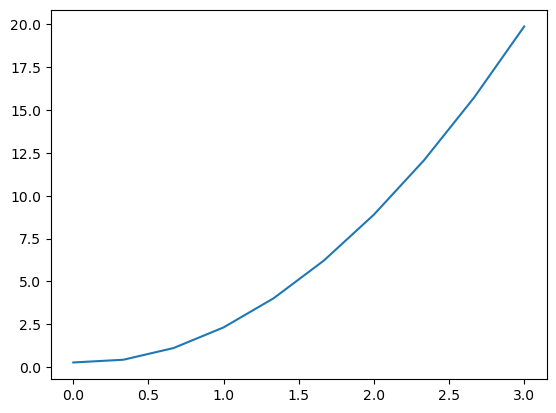

In [7]:
import copy

num_samples=1000
num_features=100
num_epochs=1000
seed=42
decor_lr=1
bias_lr=1e-1
kappa=1e-1

offsets = np.linspace(0, 3, 10)

grads = torch.zeros(len(offsets))
for i, offset in enumerate(offsets):

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    # generate correlated data
    data = generate_correlated_data(num_features, num_samples).to(device) + offset

    # create a decorrelator
    model = Decorrelation(in_features=num_features, decor_lr=decor_lr, bias_lr=bias_lr, kappa=kappa).to(device)

    w_old = copy.deepcopy(model.weight.data)
    model.forward(data)
    model.update()
    grads[i] = torch.norm(model.weight-w_old)

plt.plot(offsets, grads);

Decorrelation of a convolutional input

mean variance: 1.01


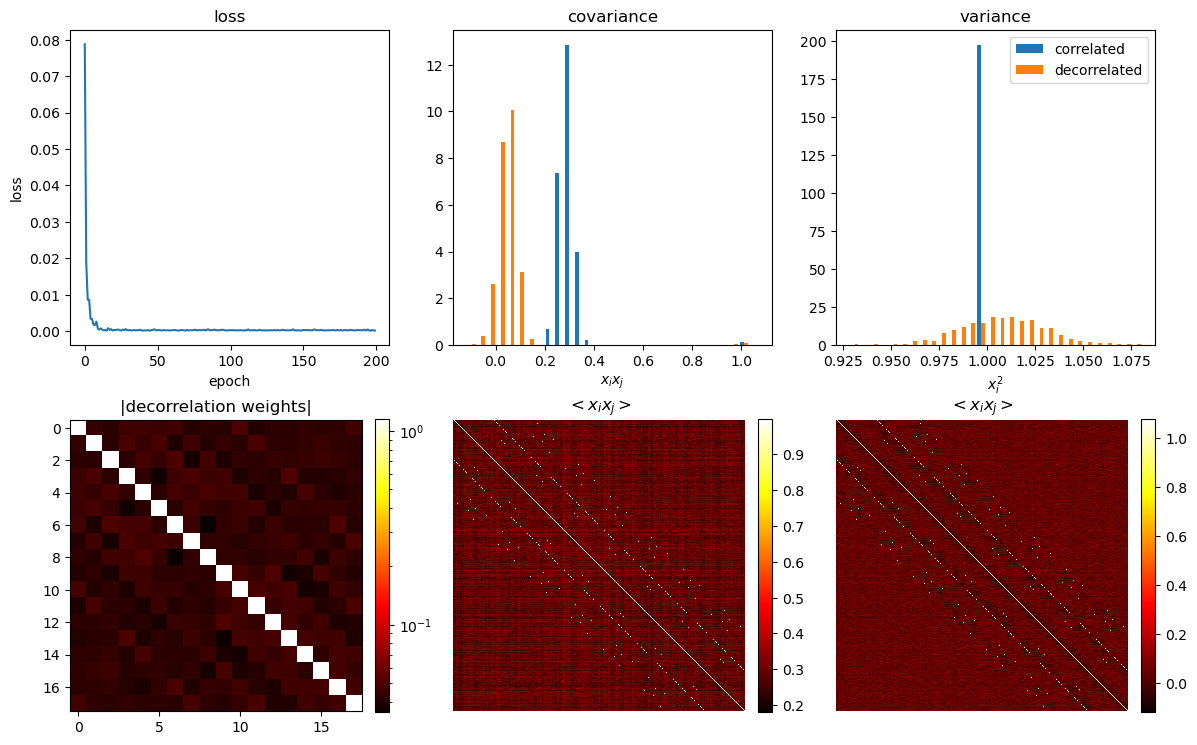

In [9]:
# generate [N, M] correlated input
num_examples=1000
in_channels=2
out_channels=3
height=10
width=10
kernel_size=(3,3)
num_samples=1000
num_epochs=200
seed=42
decor_lr=1e-0
kappa=1e-1
downsample_perc=0.1

num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

data = generate_correlated_data(num_features, num_samples).reshape(num_examples,in_channels,height,width).to(device)

# d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
# data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width).to(device)

# create a convolutional decorrelator
# NOTE: how many samples for effective input decorrelation? Dependence on dim?
# nr of samples instead of perc?
# NOTE: version for immediate non-batched decorrelation...
model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, decor_lr=decor_lr, bias_lr=bias_lr, kappa=kappa, downsample_perc=downsample_perc).to(device)

L, A1, A2 = train(num_epochs, data, model)

plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')
